1. Load mol objects and highlight sites that are being misclassified
2. A lot of the false positives are tertiary carbon atoms with high spin. Tertiary carbon atoms don't usually do as well, but the model can't tell the difference between T-carbons embedded in rings or connected to methyl groups. This could deserve its own feature
3. A lot of the false negatives are for small molecules with multiple nitrogen atoms. Correcting the aromatic ring size feature could potentially improve this. First check if the RDKit feature is trustworthy; if not, can just look for the full set of carbons with only 3 bonds, as these are necessarily sp2.
4. The aromatic ring size features appears to be completely wrong, and I found at least one counterexample for OrthoOrPara. DistanceToN may obviate OrthoOrPara anyway
5. sf189x0 has an active site at carbon 4 (binding energy -0.1eV), and a symmetric site at carbon 21 that is not active. This likely illustrates different conformers can subtely affect these energies
6. Catalyst sf41x0 lists all binding sites as inactive, but some actually are (and possibly most). If I move the correct files to the correct directory, can I just rerun Kunal's parsing scripts?

Score to beat: 95% w/ random forest on 10-fold cross validation
Since 80% of sites are not active, the threshold for success is 80%

In [2]:
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GroupKFold

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier

# Regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Data Analysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [3]:
from ngcc_ml import data_tools

In [4]:
def processData(df_in, oneHotCols=[], scaledCols=[]):
    df = df_in.copy()
    scaler = StandardScaler()
    oneHotEncoder = OneHotEncoder(categories = "auto", sparse = False)
    if scaledCols != []:
        df[scaledCols] = scaler.fit_transform(df[scaledCols])
    #if oneHotCols != []:
    #    df[encoded_columns] = oneHotEncoder.fit_transform(alldata[oneHotCols])
    return df
    

In [5]:
#df = pd.read_csv("/home/nricke/work/klodaya/notebooks_klodaya/DidItBindWithSubstructure.csv", index_col=0)
#df = pd.read_csv("/home/nricke/work/ngcc_ml/DidItBindv2.csv")
df = pd.read_csv("/home/nricke/work/ngcc_ml/DidItBindv4.csv")
df_aug = pd.read_json("/home/nricke/work/ngcc_ml/cat_aux_aromatic_flex.json")
df_aug["Atom Number"] = df_aug["Atom Number"] + 1
df_aug.drop(columns=["ring_edge", "aromatic_extent"], inplace=True)
df = df.merge(df_aug, on=["Atom Number", "Catalyst Name"])

In [6]:
#df.to_csv("/home/nricke/work/ngcc_ml/DidItBindv5.csv")

In [7]:
print(df.columns)

Index(['Atom Number', 'Catalyst Name', 'CatalystO2File', 'Element',
       'SpinDensity', 'ChElPGPositiveCharge', 'ChElPGNeutralCharge',
       'ChargeDifference', 'Doesitbind', 'BondLength', 'IonizedFreeEnergy',
       'IonizationEnergy', 'BindingEnergy', 'NeutralFreeEnergy', 'OrthoOrPara',
       'Meta', 'FartherThanPara', 'DistanceToN', 'AverageBondLength',
       'BondLengthRange', 'NumberOfHydrogens', 'AromaticSize', 'IsInRingSize6',
       'IsInRingSize5', 'NeighborSpinDensity', 'NeighborChElPGCharge',
       'NeighborChargeDifference', 'AromaticExtent', 'RingEdge',
       'NumNitrogens', 'NumHeteroatoms', 'ring_nitrogens',
       'atom_plane_deviation', 'ring_plane_deviation', 'charge'],
      dtype='object')


In [8]:
df = df[df["Catalyst Name"] != "sf7x0"]

In [9]:
feature_cols = {"SpinDensity", "ChElPGNeutralCharge", "ChargeDifference", "IonizationEnergy", "OrthoOrPara", "Meta", "FartherThanPara", "DistanceToN", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "NeighborSpinDensity", 'NeighborChElPGCharge', 'NeighborChargeDifference', "AromaticExtent", "RingEdge", "NumNitrogens", "NumHeteroatoms", "charge", "atom_plane_deviation", "ring_plane_deviation", "ring_nitrogens"}
not_scaled_cols = {"OrthoOrPara", "Meta", "FartherThanPara", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "RingEdge", "NumNitrogens", "NumHeteroatoms", "ring_nitrogens", "charge"}
df_scale = processData(df, scaledCols=list(feature_cols - not_scaled_cols))
X = df_scale[feature_cols]
y = df_scale["Doesitbind"].astype('int')

df_active = df_scale[df_scale["Doesitbind"] == 1]
X_reg = df_active[feature_cols]
y_reg = df_active["BindingEnergy"]

/home/nricke/local/opt/miniconda/envs/ds/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nricke/local/opt/miniconda/envs/ds/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X, y, test_size=0.1, random_state=0)

In [8]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=0.10, n_splits=2, random_state = 7).split(df, groups=df['Catalyst Name']))
train = df.iloc[train_inds]
test = df.iloc[test_inds]
X_train_group = train[feature_cols]
y_train_group = train["Doesitbind"].astype("int")
X_test_group = test[feature_cols]
y_test_group = test["Doesitbind"].astype("int")

In [13]:
print(len(train["Catalyst Name"].unique()))
print(len(test["Catalyst Name"].unique()))
print(len(df["Catalyst Name"].unique()))

240
27
267


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [20]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=100, class_weight={0:0.5, 1:0.5})
rfc.fit(X_train, y_train)
print('Accuracy of RFC on test set: {:.2f}'.format(rfc.score(X_test, y_test)))
print('Accuracy of RFC on training set: {:.2f}'.format(rfc.score(X_train, y_train)))
scores = cross_val_score(rfc, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy: 0.95 (+/- 0.03)


In [13]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=100, class_weight={0:0.5, 1:0.5})
rfc.fit(X_train_poly, y_train_poly)
print('Accuracy of RFC on test set: {:.2f}'.format(rfc.score(X_test_poly, y_test_poly)))
print('Accuracy of RFC on training set: {:.2f}'.format(rfc.score(X_train_poly, y_train_poly)))
scores = cross_val_score(rfc, X_poly, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy: 0.95 (+/- 0.03)


In [20]:
svc = SVC(C=2.0, kernel='poly', gamma = 'scale')
svc.fit(X_train, y_train)
print('Accuracy of RFC on test set: {:.2f}'.format(svc.score(X_test, y_test)))
print('Accuracy of RFC on training set: {:.2f}'.format(svc.score(X_train, y_train)))
scores = cross_val_score(svc, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy of RFC on test set: 0.94
Accuracy of RFC on training set: 0.96
Accuracy: 0.94 (+/- 0.03)


In [16]:
def group_split_evaluate(model, df_xy, feature_cols, target_col="Doesitbind", n_splits=10, group_col="Catalyst Name"):
    all_scores = []
    split_groups = GroupShuffleSplit(test_size=0.10, n_splits=n_splits, random_state = 7).split(df, groups=df[group_col])
    for train_inds, test_inds in split_groups:
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group = train[feature_cols]
        X_test_group = test[feature_cols]
        y_test_group = test[target_col]
        y_train_group = train[target_col]
        model.fit(X_train_group, y_train_group)
        score = model.score(X_test_group, y_test_group)
        all_scores.append(score)
        print('Accuracy of RFC on test set: {:.2f}'.format(score))
        print('Accuracy of RFC on training set: {:.2f}'.format(model.score(X_train_group, y_train_group)))
    print("mean:", np.mean(all_scores))
    
def group_kfold_evaluate(model, df_xy, feature_cols, target_col="Doesitbind", n_splits=10, group_col="Catalyst Name"):
    all_scores, all_test_idxs, all_y_test_pred = [], [], []
    split_groups = GroupKFold(n_splits=n_splits).split(df[feature_cols], df["Doesitbind"], df[group_col])
    for train_inds, test_inds in split_groups:
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group = train[feature_cols]
        X_test_group = test[feature_cols]
        y_test_group = test[target_col]
        y_train_group = train[target_col]
        model.fit(X_train_group, y_train_group)
        score = model.score(X_test_group, y_test_group)
        y_test_pred = model.predict(X_test_group)
        all_test_idxs.append(test)
        all_y_test_pred.append(y_test_pred)
        all_scores.append(score)
        print('Accuracy of RFC on test set: {:.2f}'.format(score))
        print('Accuracy of RFC on training set: {:.2f}'.format(model.score(X_train_group, y_train_group)))
    print("mean:", np.mean(all_scores))
    return all_scores, all_test_idxs, all_y_test_pred

In [24]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=100, class_weight={0:0.5, 1:0.5})
group_split_evaluate(rfc, df, feature_cols, "Doesitbind")

Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.93
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.97
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.94
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.94
Accuracy of RFC on training set: 1.00
mean: 0.9515134734947652


In [17]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=100, class_weight={0:0.5, 1:0.5})
gkf_scores, gkf_test_idxs, gkf_test_pred = group_kfold_evaluate(rfc, df, feature_cols, "Doesitbind")

Accuracy of RFC on test set: 0.96
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.94
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.97
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.94
Accuracy of RFC on training set: 1.00
Accuracy of RFC on test set: 0.95
Accuracy of RFC on training set: 1.00
mean: 0.950777001062411


In [18]:
gkf_test_idxs

[      Atom Number Catalyst Name               CatalystO2File Element  \
 216             1       sf117x0                         None       C   
 217             3       sf117x0   sf117x0O2-2_optsp_a0m2.out       C   
 218             4       sf117x0                         None       C   
 219             5       sf117x0   sf117x0O2-4_optsp_a0m2.out       C   
 220             6       sf117x0                         None       C   
 221             7       sf117x0   sf117x0O2-6_optsp_a0m2.out       C   
 297             1       sf126x0                         None       C   
 298             2       sf126x0                         None       C   
 299             3       sf126x0                         None       C   
 300             4       sf126x0   sf126x0O2-3_optsp_a0m2.out       C   
 301             5       sf126x0   sf126x0O2-4_optsp_a0m2.out       C   
 302             7       sf126x0   sf126x0O2-6_optsp_a0m2.out       C   
 303             8       sf126x0   sf126x0O2-7_opts

In [24]:
gkf_test = pd.concat(gkf_test_idxs)

In [27]:
gkf_test_pred_list = []
for gkf in gkf_test_pred:
    gkf_test_pred_list += list(gkf)

In [28]:
gkf_test["Doesitbind_pred"] = gkf_test_pred_list

In [9]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=0.10, n_splits=2, random_state = 7).split(df_active, groups=df_active['Catalyst Name']))
train = df_active.iloc[train_inds]
test = df_active.iloc[test_inds]
X_reg_train_group = train[feature_cols]
y_reg_train_group = train["BindingEnergy"]
X_reg_test_group = test[feature_cols]
y_reg_test_group = test["BindingEnergy"]

In [13]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor

In [12]:
#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#gpr = GaussianProcessRegressor(n_restarts_optimizer=9)
model = MLPRegressor(max_iter=20000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
model.fit(X_reg_train_group, y_reg_train_group)
y_reg_test_group_pred = model.predict(X_reg_test_group)
mse = mean_squared_error(y_reg_test_group, y_reg_test_group_pred, squared=False)
mae = mean_absolute_error(y_reg_test_group, y_reg_test_group_pred)
print(mse, mae)



#group_split_evaluate(gpr, df_active, feature_cols, "BindingEnergy")

0.09980932633163515 0.0738304448656331


In [14]:
r2_score(y_reg_test_group, y_reg_test_group_pred)

0.8285028804195655

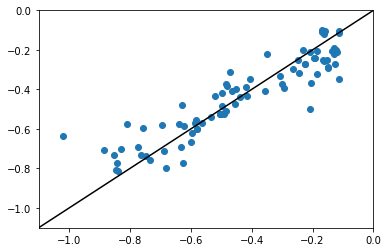

In [18]:
import matplotlib.pyplot as plt

plt.scatter(y_reg_test_group, y_reg_test_group_pred)
plt.plot([-1.1,0],[-1.1,0.], color="black")
plt.ylim([-1.1,0])
plt.xlim([-1.1,0])
plt.show()

In [ ]:
y_reg_test_group

In [18]:
y_reg_train_group.min()

-1.378672526

In [36]:
y_pred = rfc.predict(X_test)

In [37]:
confusion_matrix(y_test, y_pred)

array([[334,   4],
       [ 15,  62]])

In [25]:
# Get indices of misclassified active sites
X_test_y = X_test.copy()
X_test_y["y_pred"] = y_pred
X_test_y["y_test"] = y_test

In [26]:
X_test_y

,SpinDensity,ChElPGNeutralCharge,ChargeDifference,IonizationEnergy,OrthoOrPara,Meta,FartherThanPara,DistanceToN,NumberOfHydrogens,IsInRingSize6,...,NeighborChargeDifference,AromaticExtent,RingEdge,NumNitrogens,NumHeteroatoms,charge,atom_plane_deviation,ring_plane_deviation,y_pred,y_test
3839,0.172929,0.087672,-0.066763,0.112169,1,0,0,3,0,1,...,-0.046795,10,1,1,2,0,2.894924e-04,8.253672e-02,0,0
1587,-0.094143,-0.045620,-0.004262,0.112467,1,0,0,3,1,1,...,-0.206556,22,2,1,1,0,1.246600e-06,6.195300e-06,0,1
3307,-0.001868,-0.113641,-0.046783,0.107378,1,0,0,3,1,1,...,-0.119995,14,2,1,2,0,1.558900e-06,5.014300e-06,0,0
2801,-0.016301,0.194077,0.018759,0.134957,1,0,0,3,0,1,...,-0.125213,26,1,2,2,1,1.257963e-01,3.325958e-02,0,0
690,-0.066284,-0.252968,-0.015700,0.116005,1,0,0,1,1,1,...,-0.112705,14,2,1,1,0,3.000000e-10,6.276000e-07,0,0
2151,0.131017,-0.146973,-0.058716,0.140242,0,1,0,2,1,1,...,-0.066581,22,2,2,2,1,6.190000e-08,2.141200e-06,0,0
45,0.103984,-0.306391,-0.070399,0.131547,1,0,0,3,1,1,...,-0.030891,26,2,2,2,1,1.487000e-07,2.599700e-06,0,0
1170,-0.083431,-0.178648,-0.028146,0.114104,1,0,0,3,1,1,...,-0.186119,14,2,1,1,0,4.286000e-07,8.880000e-08,0,0
4011,-0.004732,-0.224231,0.028031,0.112159,1,0,0,1,3,0,...,-0.105489,0,0,3,3,0,0.000000e+00,0.000000e+00,0,0
1388,-0.062734,0.346745,-0.000924,0.118019,0,0,1,4,0,1,...,-0.157521,9,2,1,1,0,4.273394e-04,8.318387e-02,0,0


In [27]:
dfy = df.merge(X_test_y[["y_pred", "y_test"]], how="inner", left_index=True, right_index=True)

In [28]:
dfy_miss = dfy[dfy["y_pred"] != dfy["y_test"]]
dfy_false_pos = dfy_miss[dfy_miss["y_pred"] == 1]
dfy_false_neg = dfy_miss[dfy_miss["y_pred"] == 0]

In [31]:
dfy_false_neg[["Atom Number", "Catalyst Name", "BindingEnergy", "IonizationEnergy", "SpinDensity", "AromaticExtent", "RingEdge", "DistanceToN"]].sort_values(by="Catalyst Name")

,Atom Number,Catalyst Name,BindingEnergy,IonizationEnergy,SpinDensity,AromaticExtent,RingEdge,DistanceToN,NumNitrogens,NumHeteroatoms
70,8,sf103x0,-0.148885,0.113956,-0.062347,16,2,1,2,2
398,12,sf130x0,-0.262186,0.116031,0.314554,18,1,1,1,1
685,8,sf145x0,-0.112330,0.116005,0.248376,14,2,2,1,1
905,8,sf155x0,-0.122158,0.115284,-0.059431,14,2,1,1,1
1068,3,sf163x0,-0.348189,0.109233,0.175958,18,2,3,1,1
1587,7,sf195x0,-0.176371,0.112467,-0.094143,22,2,3,1,1
1994,10,sf21x3,-0.312524,0.135329,0.021309,13,2,1,3,3
2201,6,sf237x0,-0.141720,0.101123,0.230900,10,2,2,1,1
2531,13,sf256x0,-0.180823,0.114215,-0.084342,18,2,1,1,1
2587,13,sf259x0,-0.108101,0.108938,0.278214,18,1,1,1,1


In [32]:
dfy_false_pos[["Atom Number", "Catalyst Name", "BindingEnergy", "IonizationEnergy", "SpinDensity", "Meta", "OrthoOrPara", "DistanceToN", "NumberOfHydrogens", "AromaticExtent", "RingEdge"]].sort_values(by="Catalyst Name")

,Atom Number,Catalyst Name,BindingEnergy,IonizationEnergy,SpinDensity,Meta,OrthoOrPara,DistanceToN,NumberOfHydrogens,AromaticExtent,RingEdge
304,9,sf126x0,0.000000,0.104659,0.326079,0,1,3,0,17,2
2443,12,sf24x1,0.000000,0.102481,0.217215,0,1,1,0,15,1
2953,4,sf276x0,-0.297833,0.101115,0.249400,0,1,1,0,17,1


In [83]:
mlp = MLPClassifier(max_iter=20000, hidden_layer_sizes = (400,400,200,100,100), alpha=0.1)
mlp.fit(X_train, y_train)
print('Accuracy of MLP classifier on test set: {:.2f}'.format(mlp.score(X_test, y_test)))
print('Accuracy of MLP classifier on training set: {:.2f}'.format(mlp.score(X_train, y_train)))
#scores = cross_val_score(mlp, X, y, cv=10)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy of MLP classifier on test set: 0.95
Accuracy of MLP classifier on training set: 0.98


In [ ]:
mlp = MLPClassifier(max_iter=15000, hidden_layer_sizes = (2048, 1024, 512, 15), alpha=0.1)
mlp.fit(X_train, y_train)
print('Accuracy of MLP classifier on test set: {:.2f}'.format(mlp.score(X_test, y_test)))
print('Accuracy of MLP classifier on training set: {:.2f}'.format(mlp.score(X_train, y_train)))
scores = cross_val_score(mlp, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy of MLP classifier on test set: 0.96
Accuracy of MLP classifier on training set: 0.99
